In [219]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore") # pandas is bugging me

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import sys
sys.path.append("src")
import operator
from importlib import reload
import preprocessing.data_loading as data_loading
# import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import umap.umap_ as do_umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tensorflow import keras
from sklearn import preprocessing, manifold, decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)


 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is -0.6565247891915524


In [213]:
R3_filt_MDM2 = R3_lib.query('poi_log_fold > 3 & pvalues < 0.05').drop(['mCDH2 1','mCDH2 2','mCDH2 3'], axis=1)

R3_filt_12ca5 = R3_lib.query('poi_log_fold < -3 & pvalues < 0.05').drop(['mCDH2 1','mCDH2 2','mCDH2 3'], axis=1)

<AxesSubplot:xlabel='poi_log_fold', ylabel='poi_log_pvalue'>

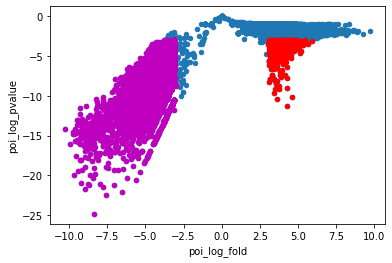

In [214]:
fig, ax = plt.subplots()
R3_lib.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', ax = ax)
R3_filt_MDM2.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'r', ax = ax)
R3_filt_12ca5.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'm', ax = ax)

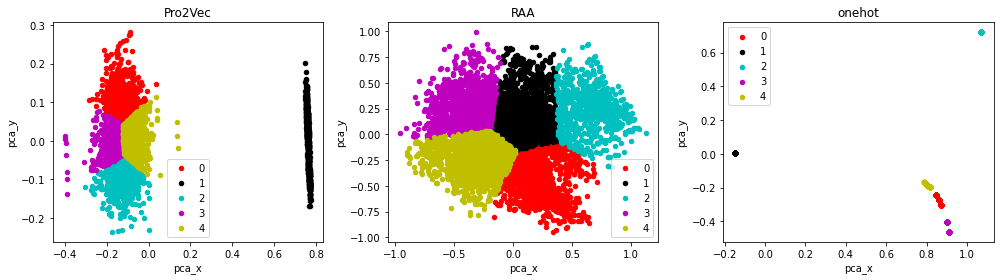

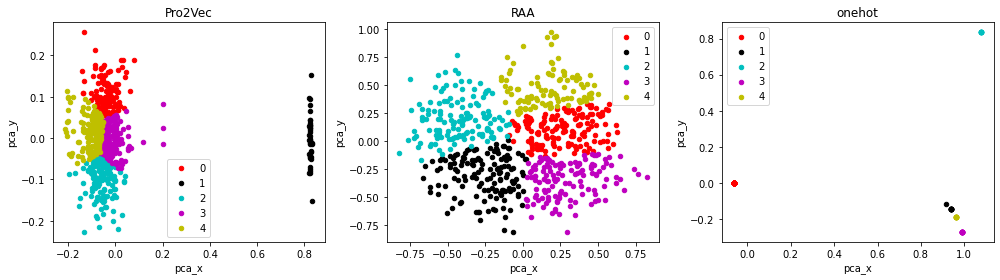

In [229]:
hit_libs = [R3_filt_12ca5,R3_filt_MDM2]
n_clusters = 5

reps = ['Pro2Vec','RAA','onehot']
prots = ['12ca5','MDM2']
colors = ['r','k','c','m','y']

for j,lib in enumerate(hit_libs):
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    for i,rep in enumerate(reps):
        data_rep = lib[rep].to_list()
        if rep == 'onehot':
            data_rep = [a[0] for a in data_rep] # fix formatting

        reducer_scaled_dict = {}
        embedding_scaled_dict = {}

        pca = decomposition.PCA(n_components=2, random_state=SEED)
        embedding = pca.fit_transform(data_rep)

        pca_fn = pca
        pca_embedding = embedding

        clusterer = Pipeline(
            [
                ('kmeans',
                 KMeans(
                     n_clusters = n_clusters,
                     init = 'k-means++',
                     n_init = 50,
                     max_iter = 500,
                     random_state = 69))])

        pipe = Pipeline(
            [
                ('clusterer',clusterer)
            ])
        # most rigorous pipeline NA    
            
        out = pipe.fit(pca_embedding)

        clusters = out['clusterer'].transform(pca_embedding)
        labels = out['clusterer']['kmeans'].labels_
        groups = np.unique(labels)

        df = pd.DataFrame()
        df['pca_x'] = pca_embedding[:,0]
        df['pca_y'] = pca_embedding[:,1]
        df['label'] = labels
        lib[f'label_{rep}_{prots[j]}'] = labels
        
        for l in np.unique(labels):
            df_sub = df.query('label == @l')
            df_sub.plot.scatter(x = 'pca_x', y = 'pca_y',c=colors[l],ax=axs[i])
        axs[i].set_title(f'{rep}')
        axs[i].legend(['0','1','2','3','4'],loc='best')
    fig.tight_layout()
    fig.show()

In [234]:
hit_libs[0].query('label_Pro2Vec_12ca5 == 1')

,Unnamed: 0,Peptide,12ca5 1,12ca5 2,12ca5 3,MDM2 1,MDM2 2,MDM2 3,12ca5 E-Score,mCDH2 E-Score,...,prop,onehot,poi_ratio,poi_log_fold,pvalues,log_pvalues,poi_log_pvalue,label_Pro2Vec_12ca5,label_RAA_12ca5,label_onehot_12ca5
0,0,KEDLRDY,3325441,3194671,3374691,32,27,1072,0.999688,0.000197,...,"[[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000114,-9.075779,4.215276e-07,-14.679381,-14.679381,1,2,2
1,1,SDVYDYS,84228,81603,87829,0,0,25,0.999665,0.000236,...,"[[-0.18, 6.5, 0.3, 0.005, 9.2, 1.67, 0.062, 1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000102,-9.185657,1.241824e-06,-13.598929,-13.598929,1,1,0
5,5,DYPDYAE,24453,24324,25526,1,2,13,0.999650,0.000135,...,"[[-0.9, 10.0, 3.0, -0.024, 13.0, 40.7, 0.105, ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000229,-8.382707,3.357739e-07,-14.906828,-14.906828,1,1,3
40,40,KVDLRDY,6078,5473,5965,1,0,7,0.999315,0.000228,...,"[[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000514,-7.573703,6.113967e-06,-12.004935,-12.004935,1,2,2
48,48,KDDLRDY,5251,4674,5133,0,0,6,0.999005,0.000597,...,"[[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000465,-7.673821,9.011867e-06,-11.616968,-11.616968,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609,5609,KEDLRVN,7,9,5,0,0,0,1.000000,0.000000,...,"[[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.045455,-3.091042,3.738446e-03,-5.589085,-5.589085,1,2,2
5612,5612,LLVLWYF,6,8,7,0,0,0,1.000000,0.000000,...,"[[1.06, -9.2, -1.8, 0.052, 4.9, 0.45, 0.186, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.045455,-3.091042,2.655052e-04,-8.233876,-8.233876,1,2,0
5614,5614,KEDLRYV,6,6,9,0,0,0,1.000000,0.000000,...,"[[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.045455,-3.091042,2.192130e-03,-6.122882,-6.122882,1,2,2
5615,5615,LLVLRDY,11,5,5,0,0,0,1.000000,0.000000,...,"[[1.06, -9.2, -1.8, 0.052, 4.9, 0.45, 0.186, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.045455,-3.091042,2.489616e-02,-3.693042,-3.693042,1,2,0


<AxesSubplot:xlabel='poi_log_fold', ylabel='poi_log_pvalue'>

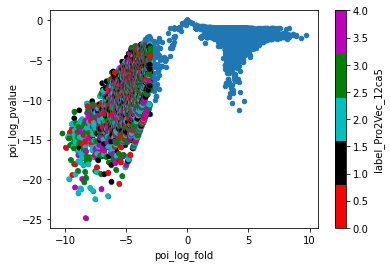

In [220]:
cmap = ListedColormap(['r','k','c','g','m']) # lol
fig, ax = plt.subplots()
R3_lib.plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', ax = ax)
hit_libs[0].plot.scatter(x = 'poi_log_fold', y = 'poi_log_pvalue', c = 'label_Pro2Vec_12ca5', colormap=cmap, ax = ax)

In [ ]:
SEED = 69

for j,lib in enumerate(hit_libs):
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    for i,rep in enumerate(reps):
        data_rep = lib[rep].to_list()
        if rep == 'onehot':
            data_rep = [a[0] for a in data_rep] # fix formatting

        n_neighbors = 8
        reducer_scaled = do_umap.UMAP(
            n_components=2, n_neighbors=2**n_neighbors, 
            random_state=SEED, metric='rogerstanimoto')
        embedding_scaled = reducer_scaled.fit_transform(data_rep)

        umap_fn = reducer_scaled
        umap_embedding = embedding_scaled

        clusterer = Pipeline(
            [
                ('kmeans',
                 KMeans(
                     n_clusters = n_clusters,
                     init = 'k-means++',
                     n_init = 50,
                     max_iter = 500,
                     random_state = 69))])

        pipe = Pipeline(
            [
                ('clusterer',clusterer)
            ])
        # most rigorous pipeline NA    
            
        out = pipe.fit(pca_embedding)

        clusters = out['clusterer'].transform(umap_embedding)
        labels = out['clusterer']['kmeans'].labels_
        groups = np.unique(labels)

        df = pd.DataFrame()
        df['umap_x'] = umap_embedding[:,0]
        df['umap_y'] = umap_embedding[:,1]
        df['label'] = labels
        lib[f'umap_label_{rep}_{prots[j]}'] = labels
        
        for l in np.unique(labels):
            df_sub = df.query('label == @l')
            df_sub.plot.scatter(x = 'umap_x', y = 'umap_y',c=colors[l],ax=axs[i])
        axs[i].set_title(f'{rep}')
        axs[i].legend(['0','1','2','3','4'],loc='best')
    fig.tight_layout()
    fig.show()